In [3]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [4]:
df = web.DataReader('GOOG', data_source='yahoo',start='2012-01-01', end='2022-02-16')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,332.827484,324.966949,325.250885,331.462585,7380561.0,331.462585
2012-01-04,333.873566,329.076538,331.273315,332.892242,5749470.0,332.892242
2012-01-05,330.745270,326.889740,329.828735,328.274536,6590410.0,328.274536
2012-01-06,328.767700,323.681763,328.344299,323.796326,5405987.0,323.796326
2012-01-09,322.291962,309.455078,322.042908,310.067780,11688849.0,310.067780
...,...,...,...,...,...,...
2022-02-10,2828.620117,2761.000000,2790.000000,2772.050049,1650900.0,2772.050049
2022-02-11,2785.665039,2665.770020,2775.000000,2682.600098,1937700.0,2682.600098
2022-02-14,2723.330078,2666.040039,2667.310059,2706.000000,1338700.0,2706.000000


In [39]:
data = df.filter(['Close'])
dataset=data.values
training_data_len = math.ceil(len(dataset)*.77)
training_data_len

1963

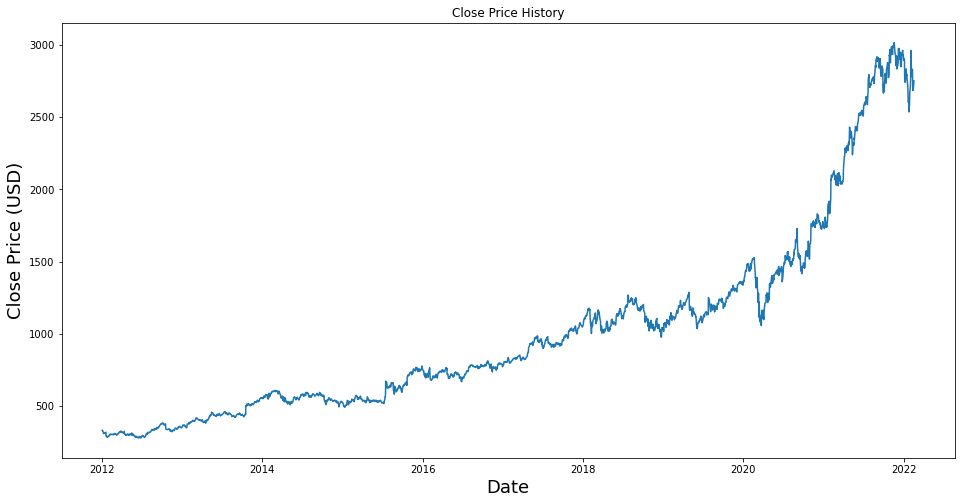

In [40]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [41]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.01936668],
       [0.01988928],
       [0.01820133],
       ...,
       [0.88734873],
       [0.89557698],
       [0.90334099]])

In [42]:
train_data = scaled_data[0:training_data_len , :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.01936668, 0.01988928, 0.01820133, 0.01656438, 0.01154608,
       0.01166991, 0.01218339, 0.01285346, 0.01200677, 0.01266046,
       0.01344889, 0.01466159, 0.0049054 , 0.00481982, 0.00398405,
       0.00190099, 0.00164789, 0.00381107, 0.00339409, 0.00383474,
       0.00396584, 0.00474517, 0.00678818, 0.00911159, 0.00868915,
       0.00924999, 0.00954314, 0.00853257, 0.00967788, 0.0092336 ,
       0.00846884, 0.00864364, 0.00830132, 0.01000564, 0.0089022 ,
       0.00856898, 0.00925909, 0.00915165, 0.01080499, 0.0107795 ,
       0.01153516, 0.01132577, 0.01005116, 0.00835958, 0.00869462,
       0.00875653, 0.00750196, 0.00839417, 0.01069393, 0.01036799,
       0.01130391, 0.01201587, 0.01364372, 0.0135545 , 0.01473624,
       0.0158415 , 0.01521149, 0.01643874, 0.01601813, 0.01760956])]
[0.016271218787306516]



In [43]:
x_train,y_train = np.array(x_train), np.array(y_train)

In [44]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1], 1))
x_train.shape

(1903, 60, 1)

In [45]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [46]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [47]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

1903/1903 [==============================] - 74s 34ms/step - loss: 3.1903e-04


In [48]:
test_data = scaled_data[training_data_len-60: , :]
x_test=[]
y_test=dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [49]:
x_test = np.array(x_test)

In [50]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [51]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [52]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

4.666155401757146

C:\Users\kapoo\AppData\Local\Temp/ipykernel_14272/2133332622.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


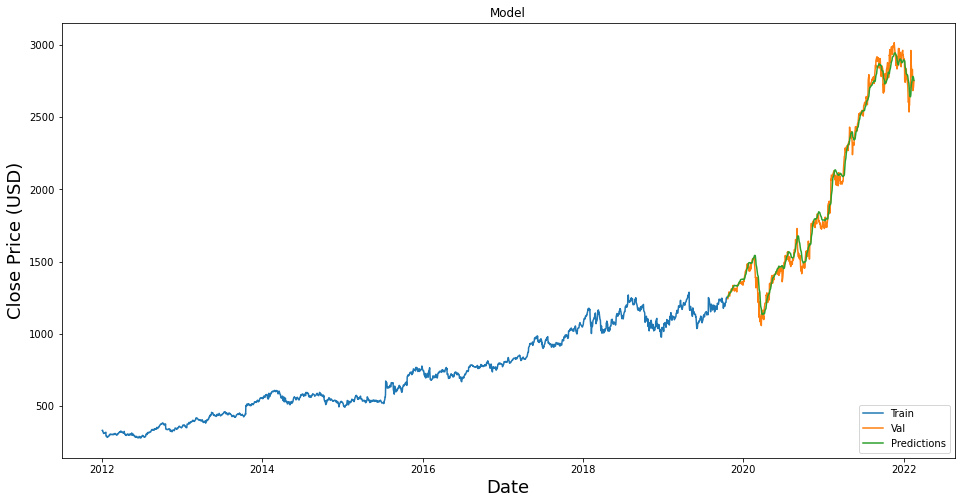

In [53]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc ='lower right')
plt.show()

In [54]:
valid

,Close,Predictions
Date,,
2019-10-22,1242.800049,1252.045166
2019-10-23,1259.130005,1255.611816
2019-10-24,1260.989990,1259.835327
2019-10-25,1265.130005,1264.146729
2019-10-28,1290.000000,1268.514648
...,...,...
2022-02-10,2772.050049,2779.012451
2022-02-11,2682.600098,2781.376465
2022-02-14,2706.000000,2772.406250


In [55]:
goog_quote = web.DataReader('GOOG', data_source='yahoo',start='2012-01-01', end='2022-02-16')
new_df = goog_quote.filter(['Close'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test=[]
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[130.83286]]


In [56]:
goog_quote2 = web.DataReader('GOOG', data_source='yahoo',start='2012-01-01', end='2022-02-16')
print(goog_quote2['Close'])

Date
2012-01-03     331.462585
2012-01-04     332.892242
2012-01-05     328.274536
2012-01-06     323.796326
2012-01-09     310.067780
                 ...     
2022-02-10    2772.050049
2022-02-11    2682.600098
2022-02-14    2706.000000
2022-02-15    2728.510010
2022-02-16    2749.750000
Name: Close, Length: 2549, dtype: float64
